# Cartpole-v0 
# Shahid Gulzar Padder
# XPXSKK

0
0.1 )the system  has converged  after  683  episodes.
0.2 )the system  has converged  after  613  episodes.
0.3 )the system  has converged  after  121  episodes.
0.5 )the system  has converged  after  692  episodes.
0.7 )the system  has converged  after  344  episodes.
1
0.1 )the system  has converged  after  587  episodes.
0.2 )the system  has converged  after  317  episodes.
0.3 )the system  has converged  after  389  episodes.
0.5 )the system  has converged  after  693  episodes.
0.7 )the system  has converged  after  296  episodes.
2
0.1 )the system  has converged  after  689  episodes.
0.2 )the system  has converged  after  855  episodes.
0.3 )the system  has converged  after  407  episodes.
0.5 )the system  has converged  after  270  episodes.
0.7 )the system  has converged  after  403  episodes.
3
0.1 )the system  has converged  after  674  episodes.
0.2 )the system  has converged  after  365  episodes.
0.3 )the system  has converged  after  1593  episodes.
0.5 )the system  ha

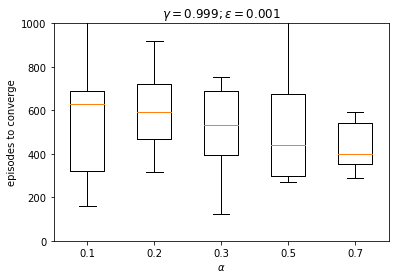

In [1]:
import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def sarsa_control(env, max_num_episodes, discount=1.0, eps=0.99, alpha=0.05):
    """Sarsa control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = build_state(env.reset())
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)
        probs = policy(state)
        action = rnd.choice(possible_actions, p=probs)

        for t in itertools.count():
            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            next_state = build_state(next_state)

            # predict next action
            probs = policy(next_state)
            next_action = rnd.choice(possible_actions, p=probs)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Sarsa update rule
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][next_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state, action = next_state, next_action

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = ALPHA_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    array_eps_to_conv = []
    if (mode == EPS_ANALYSIS):
        eval_array = [0.001,0.003,0.006,0.01,0.013]
    elif (mode == ALPHA_ANALYSIS):
        eval_array = [0.1,0.2,0.3,0.5,0.7]
    else:
        eval_array = [0.999,0.8,0.7,0.6,0.5]

    for t in range(NUM_ITERATIONS):
        array_temp = []
        print(t)

        for hyperparameter in eval_array:
            if (mode == EPS_ANALYSIS):
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, discount, hyperparameter, alpha)
            elif (mode == ALPHA_ANALYSIS):
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, discount, eps, hyperparameter)
            else:
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, hyperparameter, eps, alpha)

            array_temp.append(episodes_to_converge)
            print(hyperparameter, ")the system ", "has converged" if (has_converged) else "hasn't converged", " after ", episodes_to_converge, " episodes.")

        array_eps_to_conv.append(array_temp)

    array_eps_to_conv = np.array(array_eps_to_conv)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if (mode == EPS_ANALYSIS):
        title = r'$\gamma = {:.3f}; \alpha = {:.3f}$'.format(discount, alpha)
        label = r'$\epsilon$'
        name = 'eps_sensibility1.png'
        ax.set_ylim((0,2000))
    elif (mode == ALPHA_ANALYSIS):
        title = r'$\gamma = {:.3f}; \epsilon = {:.3f}$'.format(discount, eps)
        label = r'$\alpha$'
        name = 'lr_sensibility1.png'
        ax.set_ylim((0,1000))
    else:
        title = r'$\alpha = {:.3f}; \epsilon = {:.3f}$'.format(alpha, eps)
        label = r'$1-\gamma$'
        eval_array = [np.around(1-disc, decimals=4) for disc in eval_array]
        name = 'discount_sensibility1.png'
        ax.set_ylim((0,1500))

    ax.set_title(title)
    ax.set_ylabel('episodes to converge')
    ax.set_xlabel(label)
    ax.boxplot(array_eps_to_conv, labels=eval_array)
    plt.savefig(name)
    #plt.show()

0
0.001 )the system  has converged  after  388  episodes.
0.003 )the system  has converged  after  970  episodes.
0.006 )the system  has converged  after  734  episodes.
0.01 )the system  has converged  after  1233  episodes.
0.013 )the system  has converged  after  705  episodes.
1
0.001 )the system  has converged  after  451  episodes.
0.003 )the system  has converged  after  393  episodes.
0.006 )the system  has converged  after  1212  episodes.
0.01 )the system  has converged  after  964  episodes.
0.013 )the system  has converged  after  713  episodes.
2
0.001 )the system  has converged  after  671  episodes.
0.003 )the system  has converged  after  618  episodes.
0.006 )the system  has converged  after  2165  episodes.
0.01 )the system  has converged  after  1254  episodes.
0.013 )the system  has converged  after  1143  episodes.
3
0.001 )the system  has converged  after  635  episodes.
0.003 )the system  has converged  after  641  episodes.
0.006 )the system  has converged  afte

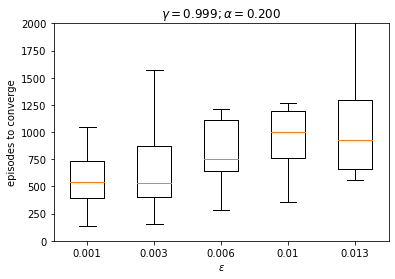

In [2]:
import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def sarsa_control(env, max_num_episodes, discount=1.0, eps=0.99, alpha=0.05):
    """Sarsa control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = build_state(env.reset())
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)
        probs = policy(state)
        action = rnd.choice(possible_actions, p=probs)

        for t in itertools.count():
            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            next_state = build_state(next_state)

            # predict next action
            probs = policy(next_state)
            next_action = rnd.choice(possible_actions, p=probs)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Sarsa update rule
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][next_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state, action = next_state, next_action

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = EPS_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    array_eps_to_conv = []
    if (mode == EPS_ANALYSIS):
        eval_array = [0.001,0.003,0.006,0.01,0.013]
    elif (mode == ALPHA_ANALYSIS):
        eval_array = [0.1,0.2,0.3,0.5,0.7]
    else:
        eval_array = [0.999,0.8,0.7,0.6,0.5]

    for t in range(NUM_ITERATIONS):
        array_temp = []
        print(t)

        for hyperparameter in eval_array:
            if (mode == EPS_ANALYSIS):
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, discount, hyperparameter, alpha)
            elif (mode == ALPHA_ANALYSIS):
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, discount, eps, hyperparameter)
            else:
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, hyperparameter, eps, alpha)

            array_temp.append(episodes_to_converge)
            print(hyperparameter, ")the system ", "has converged" if (has_converged) else "hasn't converged", " after ", episodes_to_converge, " episodes.")

        array_eps_to_conv.append(array_temp)

    array_eps_to_conv = np.array(array_eps_to_conv)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if (mode == EPS_ANALYSIS):
        title = r'$\gamma = {:.3f}; \alpha = {:.3f}$'.format(discount, alpha)
        label = r'$\epsilon$'
        name = 'eps_sensibility1.png'
        ax.set_ylim((0,2000))
    elif (mode == ALPHA_ANALYSIS):
        title = r'$\gamma = {:.3f}; \epsilon = {:.3f}$'.format(discount, eps)
        label = r'$\alpha$'
        name = 'lr_sensibility1.png'
        ax.set_ylim((0,1000))
    else:
        title = r'$\alpha = {:.3f}; \epsilon = {:.3f}$'.format(alpha, eps)
        label = r'$1-\gamma$'
        eval_array = [np.around(1-disc, decimals=4) for disc in eval_array]
        name = 'discount_sensibility1.png'
        ax.set_ylim((0,1500))

    ax.set_title(title)
    ax.set_ylabel('episodes to converge')
    ax.set_xlabel(label)
    ax.boxplot(array_eps_to_conv, labels=eval_array)
    plt.savefig(name)
    #plt.show()

0
0.999 )the system  has converged  after  585  episodes.
0.8 )the system  has converged  after  516  episodes.
0.7 )the system  has converged  after  1720  episodes.
0.6 )the system  has converged  after  4259  episodes.
0.5 )the system  hasn't converged  after  5999  episodes.
1
0.999 )the system  has converged  after  328  episodes.
0.8 )the system  has converged  after  708  episodes.
0.7 )the system  has converged  after  787  episodes.
0.6 )the system  has converged  after  1298  episodes.
0.5 )the system  has converged  after  1422  episodes.
2
0.999 )the system  has converged  after  274  episodes.
0.8 )the system  has converged  after  410  episodes.
0.7 )the system  has converged  after  1780  episodes.
0.6 )the system  has converged  after  1990  episodes.
0.5 )the system  has converged  after  984  episodes.
3
0.999 )the system  has converged  after  1766  episodes.
0.8 )the system  has converged  after  366  episodes.
0.7 )the system  has converged  after  488  episodes.
0

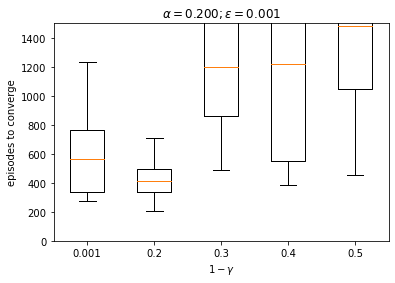

In [3]:
import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def sarsa_control(env, max_num_episodes, discount=1.0, eps=0.99, alpha=0.05):
    """Sarsa control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = build_state(env.reset())
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)
        probs = policy(state)
        action = rnd.choice(possible_actions, p=probs)

        for t in itertools.count():
            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            next_state = build_state(next_state)

            # predict next action
            probs = policy(next_state)
            next_action = rnd.choice(possible_actions, p=probs)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Sarsa update rule
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][next_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state, action = next_state, next_action

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = DISCOUNT_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    array_eps_to_conv = []
    if (mode == EPS_ANALYSIS):
        eval_array = [0.001,0.003,0.006,0.01,0.013]
    elif (mode == ALPHA_ANALYSIS):
        eval_array = [0.1,0.2,0.3,0.5,0.7]
    else:
        eval_array = [0.999,0.8,0.7,0.6,0.5]

    for t in range(NUM_ITERATIONS):
        array_temp = []
        print(t)

        for hyperparameter in eval_array:
            if (mode == EPS_ANALYSIS):
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, discount, hyperparameter, alpha)
            elif (mode == ALPHA_ANALYSIS):
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, discount, eps, hyperparameter)
            else:
                has_converged, episodes_to_converge = sarsa_control(env, max_num_episodes, hyperparameter, eps, alpha)

            array_temp.append(episodes_to_converge)
            print(hyperparameter, ")the system ", "has converged" if (has_converged) else "hasn't converged", " after ", episodes_to_converge, " episodes.")

        array_eps_to_conv.append(array_temp)

    array_eps_to_conv = np.array(array_eps_to_conv)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if (mode == EPS_ANALYSIS):
        title = r'$\gamma = {:.3f}; \alpha = {:.3f}$'.format(discount, alpha)
        label = r'$\epsilon$'
        name = 'eps_sensibility1.png'
        ax.set_ylim((0,2000))
    elif (mode == ALPHA_ANALYSIS):
        title = r'$\gamma = {:.3f}; \epsilon = {:.3f}$'.format(discount, eps)
        label = r'$\alpha$'
        name = 'lr_sensibility1.png'
        ax.set_ylim((0,1000))
    else:
        title = r'$\alpha = {:.3f}; \epsilon = {:.3f}$'.format(alpha, eps)
        label = r'$1-\gamma$'
        eval_array = [np.around(1-disc, decimals=4) for disc in eval_array]
        name = 'discount_sensibility1.png'
        ax.set_ylim((0,1500))

    ax.set_title(title)
    ax.set_ylabel('episodes to converge')
    ax.set_xlabel(label)
    ax.boxplot(array_eps_to_conv, labels=eval_array)
    plt.savefig(name)
    #plt.show()